<a href="https://colab.research.google.com/github/ane-schow/CCA/blob/main/artigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cmocean
!pip install copernicusmarine
!pip install cartopy
import copernicusmarine as cm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from datetime import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import maximum_filter
from scipy.ndimage import minimum_filter
import cmocean

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 3.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=a8ca902ed3866102a66aa409340beb5be07807bb9a34b24360ab6e28dfd4dd68
  Stored in directory: /root/.cache/pip/wheels/71/c1/da/23077eb3b87d24d6f3852ed1ed1a1ac2d3c885ad6ebd2b4a07
Successfully built asciitree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
cm.login

<function copernicusmarine.python_interface.login.login(username: Optional[str] = None, password: Optional[str] = None, configuration_file_directory: pathlib.Path = PosixPath('/root/.copernicusmarine'), force_overwrite: bool = False, check_credentials_valid: bool = False, credentials_file: Optional[pathlib.Path] = None) -> bool>

In [ ]:
cm.subset(
    dataset_id = "cmems_mod_glo_phy_my_0.083deg_P1M-m",
    variables = ["thetao","uo"],
    minimum_longitude = -96.507293,
    maximum_longitude = -63.336000,
    minimum_latitude = -74.390233,
    maximum_latitude = -52.683000,
    start_datetime = "1993-01-01T00:00:00",
    end_datetime = "1994-01-01T00:00:00",
    minimum_depth =0,
    maximum_depth =400,
    output_filename = "saf_pf.nc",
    output_directory = "artigo"
)

INFO - 2025-03-15T18:50:37Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: aschowantz
Copernicus Marine password: ··········


INFO - 2025-03-15T18:50:52Z - Selected dataset version: "202311"
INFO:copernicusmarine:Selected dataset version: "202311"
INFO - 2025-03-15T18:50:52Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
WARNING - 2025-03-15T18:51:01Z - Some of your subset selection [0, 400] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-03-15T18:51:05Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/5280 [00:00<?, ?it/s]

INFO - 2025-03-15T18:57:19Z - Successfully downloaded to artigo/saf_pf_(1).nc
INFO:copernicusmarine:Successfully downloaded to artigo/saf_pf_(1).nc


ResponseSubset(file_path=PosixPath('artigo/saf_pf_(1).nc'), output_directory=PosixPath('artigo'), filename='saf_pf_(1).nc', file_size=154.0481145038168, data_transfer_size=4464.9526717557255, variables=['thetao', 'uo'], coordinates_extent=[GeographicalExtent(minimum=-96.5, maximum=-63.41666793823242, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=-74.33333587646484, maximum=-52.75, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='1993-01-01T00:00:00+00:00', maximum='1994-01-01T00:00:00+00:00', unit='iso8601', coordinate_id='time'), GeographicalExtent(minimum=0.49402499198913574, maximum=380.2130126953125, unit='m', coordinate_id='depth')], status='000', message='The request was successful.', file_status='DOWNLOADED')

In [ ]:
fn = '/content/artigo/saf_pf.nc'
ds = xr.open_dataset(fn)

In [ ]:
temp = ds['thetao']
u0 = ds['uo']
prof = temp['depth']
latitude = temp['latitude']
longitude = u0['longitude']
R = 6371000
sv_factor = 1e6

In [ ]:
def transporte_corrente(u, p, lat):
  delta_lat = np.diff(lat)
  delta_lat_rad = np.radians(delta_lat)
  dist_cel = (R * delta_lat_rad)
  delta_p = np.diff(p)

  u = u.transpose()
  c = u[:-1, :-1]

  masc = ~np.isnan(c)
  area_cel = np.outer(dist_cel, delta_p)
  transporte_cel = c * area_cel * masc

  transporte_total = transporte_cel.sum(axis=1)
  transporte_sv = transporte_total / sv_factor
  return xr.DataArray(transporte_sv, coords={"latitude": lat[:-1]}, dims=["latitude"])

In [ ]:
transportes = []

for i in range(u0['time'].size):
    transporte_temp = []
    latitudes_temp = []
    for x in range(u0['longitude'].size):
        u = u0.isel(time=i, longitude=x).squeeze()
        p = u['depth']
        lat = u['latitude']
        transporte = transporte_corrente(u, p, lat)
        transporte_temp.append(transporte)
    transportes.append(transporte_temp)

In [ ]:
transportes_array = xr.DataArray(transportes, dims=['time', 'longitude', 'latitude'],
                                  coords={'time': u0['time'],
                                          'longitude': u0['longitude'],
                                          'latitude': transporte.latitude})
transportes_array = transportes_array.transpose('time', 'latitude', 'longitude')
print(transportes_array.shape, transportes_array.dims)

(13, 259, 398) ('time', 'latitude', 'longitude')


In [ ]:
ds_transportes = transportes_array.isel(time=0,longitude=169)
lati = ds_transportes['latitude']
temp_slice = temp.isel(time=0, longitude=169)

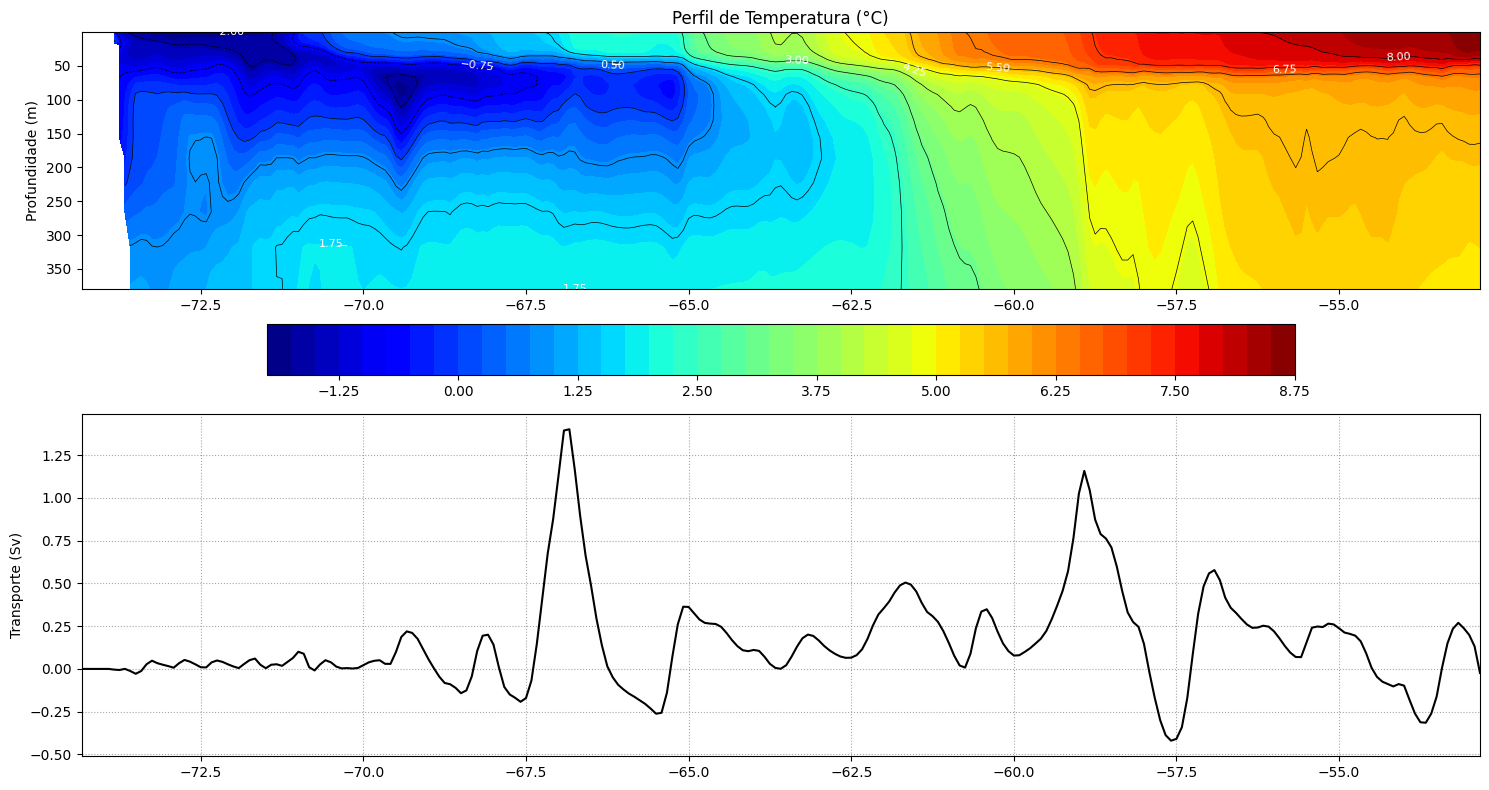

In [ ]:
fig,(ax1, ax2)= plt.subplots(2, 1, figsize=(15, 8))

cntr = ax1.contourf(latitude, prof, temp_slice, levels=50,cmap='jet')
cntr_lines = ax1.contour(latitude, prof, temp_slice, levels=15, colors='k', linewidths=0.5)

c = fig.colorbar(cntr, ax=ax1, orientation='horizontal', pad=0.1)

ax1.invert_yaxis()
ax1.clabel(cntr, levels=cntr.levels[::5], colors='w', fontsize=8)
ax1.set_ylabel('Profundidade (m)')
ax1.set_title("Perfil de Temperatura (°C)")
ax1.set_xlim(-74.33333588, -52.83333206)

ax2.plot(lati, ds_transportes, linestyle='-', color='k', label='Transporte')
ax2.set_ylabel('Transporte (Sv)')
ax2.grid(color='gray',alpha=0.7, linestyle=':')
ax2.set_xlim(-74.33333588, -52.83333206)

plt.tight_layout()
plt.show()

# Para achar a pf

In [ ]:
condicao_temp = temp<= 3
transporte_maximos = maximum_filter(transportes_array, size=(1, 91, 1))
mascara_picos = transportes_array == transporte_maximos

resultados = []

for t in range(temp.shape[0]):
    for lat in range(temp.shape[2]):
        for lon in range(temp.shape[3]):
            if condicao_temp[t, :, lat, lon].any():
                if mascara_picos[t, lat, lon]:
                    resultados.append((temp['time'][t].values,
                                       temp['latitude'][lat].values,
                                       temp['longitude'][lon].values))

In [ ]:
loc_pf = xr.DataArray(
    data=np.array(resultados),
    dims=["index", "coord"],
    coords={"index": np.arange(len(resultados)), "coord": ["time", "lat", "lon"]},
    name="picos_validos"
)


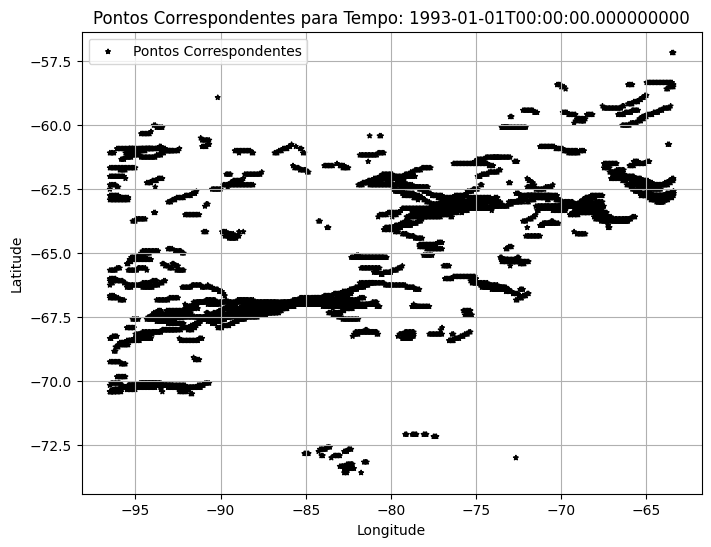

In [ ]:
tempo_teste = loc_pf.sel(index=0)

latitudes = loc_pf.sel(coord="lat").values
longitudes = loc_pf.sel(coord="lon").values

plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, s=12, marker='*', facecolors='none', edgecolors='k', label="Pontos Correspondentes")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Pontos Correspondentes para Tempo: {tempo_teste.sel(coord='time').values}")
plt.legend()
plt.grid(True)

plt.show()
